# Creating a classifier for both numerical and categorical data

Nesse jupyter notebook vamos explorar duas questões, primeiro vamos realizar o treinamento de um classificador
kNN usando as variáveis numéricas, depois vamos realizar alguns pré-processamentos nos dados para repetir o experimento.

In [136]:
import pandas as pd
dataset = pd.read_csv("data\\adult-census.csv")

Lets have a look at the first records of this dataframe:

In [137]:
dataset.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


The first step is to separate columns to get on one side the target and on the other side the data.

In [138]:
target_name = "class"
y = dataset[target_name]
y

0         <=50K
1         <=50K
2          >50K
3          >50K
4         <=50K
          ...  
48837     <=50K
48838      >50K
48839     <=50K
48840     <=50K
48841      >50K
Name: class, Length: 48842, dtype: object

In [139]:
x = dataset.drop("class", axis=1)
x.head(6)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States


We can now linger on the variables, also denominated features, that we will use to build our predictive model. In addition, we can also check how many samples are available in our dataset.

In [140]:
x.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')

In [141]:
# "#something" -> number of something
print("#examples = {} #features = {}".format(x.shape[0], x.shape[1]))

#examples = 48842 #features = 14


In [142]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      48842 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48842 non-null  object
dtypes: int64(6), object(8)
memory usage: 5.2+ MB


## Select features based on their data type

dtype identifies categorical and numerical variables. <br> Sklearn has `make_column_selector` to select different features based on target atributes. <br>
`x.info()` belowe show us, if numerical variable, dtype: int, if categorical variable (string), dtype: object

In [143]:
from sklearn.compose import make_column_selector as selector

# Selector => Create a callable to select columns to be used with ColumnTransformer.
numerical_cols_sel   = selector(dtype_exclude=object)
categorical_cols_sel = selector(dtype_include=object)

In [144]:
numerical_columns = numerical_cols_sel(x)
categorical_columns = categorical_cols_sel(x)

In [145]:
print(categorical_columns)

['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


### Identify categorical variables

In [146]:
# Note that this dataset has missing values (represented by "?")
for col in categorical_columns:
    print(x[col].value_counts().sort_index(), "\n")
    break # ... 


 ?                    2799
 Federal-gov          1432
 Local-gov            3136
 Never-worked           10
 Private             33906
 Self-emp-inc         1695
 Self-emp-not-inc     3862
 State-gov            1981
 Without-pay            21
Name: workclass, dtype: int64 



In [147]:
print(numerical_columns)

['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']


## Strategies to encode categories

### Ordinal vs nominal categories

An ordinal variable is similar to a categorical variable. <br>
The difference between the two is that there is a clear ordering of the categories. <br>
For example, suppose you have a variable, economic status, with three categories (low, medium and high).

If a categorical variable does not carry any meaningful order information then this encoding might be misleading to downstream statistical models and **you might consider using one-hot encoding instead (see below).**

### Encoding nominal categories (without assuming any order)

Scikit-learn has `ColumnTransformer` class which facilitates the classifier that will consider both categorial and numerical variables.


* **one-hot encoding**  is designed to nominal categorical variable. When this parameter (`handle_unknown="ignore"`) is set to ‘ignore’ and an unknown category is encountered during transform, the resulting one-hot encoded columns for this feature will be all zeros. 
* **numerical scaling** standardize features by removing the mean and scaling to unit variance. The standard score of a sample x is calculated as:
$z = (x - u) / s$
where $u$ is the mean of the training samples or zero if with_mean=False, and $s$ is the standard deviation of the training samples or one if with_std=False.

In [148]:
# setting transformations
from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor   = StandardScaler()

After that we create the `ColumnTransformer` and associate the preprocessors defined above with it,
 together with the respective categorical and numerical columns.

In [149]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('standard-scaler', numerical_preprocessor, numerical_columns)])

In [150]:
preprocessor

ColumnTransformer(transformers=[('one-hot-encoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['workclass', 'education', 'marital-status',
                                  'occupation', 'relationship', 'race', 'sex',
                                  'native-country']),
                                ('standard-scaler', StandardScaler(),
                                 ['age', 'fnlwgt', 'education-num',
                                  'capital-gain', 'capital-loss',
                                  'hours-per-week'])])

In [151]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

model = make_pipeline(preprocessor, KNeighborsClassifier(n_neighbors=3))

O código abaixo só mostra o modelo em forma gráfica. Normalmente não fazemos isso na prática, mas enquanto estamos aprendendo pode ajudar a compreender o que é o pipeline.

In [152]:
from sklearn import set_config
set_config(display='diagram')
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country']),
                                                 ('standard-scaler',
                                                  StandardScaler(),
                                                  ['age', 'fnlwgt',
                                                   'education-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week'])])),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=3))])

Os modelos do sklearn seguem uma API bastante padronizada, espere encontrar os métodos abaixo em diferentes modelos:

- `fit` method is called to preprocess the data and then train the
  classifier of the preprocessed data;
- `predict` method makes predictions on new data;
- `score` method is used to predict on the test data and compare the
  predictions to the expected test labels to compute the accuracy.

Nós ainda não falamos de melhores práticas para estimativa de erro, por hora vamos usar a abordagem mais simples. Holdout: reservamos uma fatia do nosso dataset para treino e outra para teste.

In [153]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x, y, random_state=42)

In [154]:
_ = model.fit(x_train, y_train)

In [155]:
x_test.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
7762,56,Private,33115,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,0,40,United-States
23881,25,Private,112847,HS-grad,9,Married-civ-spouse,Transport-moving,Own-child,Other,Male,0,0,40,United-States
30507,43,Private,170525,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,14344,0,40,United-States
28911,32,Private,186788,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States
19484,39,Private,277886,Bachelors,13,Married-civ-spouse,Sales,Wife,White,Female,0,0,30,United-States


In [156]:
y_hat = model.predict(x_test)
y_hat[:5]

array([' <=50K', ' <=50K', ' >50K', ' <=50K', ' >50K'], dtype=object)

In [157]:
y_test[:5]

7762      <=50K
23881     <=50K
30507      >50K
28911     <=50K
19484     <=50K
Name: class, dtype: object

In [158]:
# accuracy
model.score(x_test,y_test)

0.8281876996151012

No próximo bloco fazemos um plot da matriz de confusão e printamos também
um relatório de classificação que contém as principais métricas de classificadores.

              precision    recall  f1-score   support

       <=50K       0.88      0.90      0.89      9354
        >50K       0.64      0.60      0.62      2857

    accuracy                           0.83     12211
   macro avg       0.76      0.75      0.76     12211
weighted avg       0.82      0.83      0.83     12211



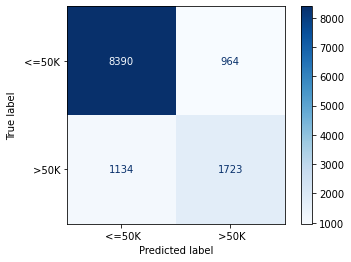

In [159]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_hat, labels=model.classes_)
display_confusion_matrix = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
display_confusion_matrix.plot(cmap=plt.cm.Blues)
print(classification_report(y_test, y_hat))

Neste jupyter notebook nós usamos:

* `ColumnTransformer` para aplicar diferentes pré-processamentos em dados numéricos e categóricos;
* usamos o Pipeline para encadear o `ColumnTransformer` com o kNN;